# Allen Institute
## 04-2_hyperparams_important_feats
---
## Dataset
- `../data/m1_10x_ml/ref_top1000_log.pkl`

## WorkFlow
- Hyperparameter tuning
 
 **Notes)**
 
 if kernel dies during running codes, you can ommit completed sections indexed if alphabets

In [1]:
import json
import os
from typing import NamedTuple, Dict, List, Union

import matplotlib.pyplot as plt
import numpy as np
import optuna.integration.lightgbm as lgb
import pandas as pd
import seaborn as sns

from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import label_binarize
from tqdm.notebook import tqdm

from tools.figure import boxplot, cns_markers, fig_kwarg
from tools.random import iterative_seed

In [2]:
with open(f"../data/grn_features.json", mode="r") as f:
    feat = json.load(f)

In [3]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_ml/train_top1000_log.pkl"
    ).loc[:, feat["m1_10x"]]
    label: pd.core.frame.DataFrame = pd.read_csv(
        "../data/m1_10x_meta/metadata.csv", index_col=0
    )
    test_data: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_ml/test_top1000_log.pkl"
    ).loc[:, feat["m1_10x"]]
    n: int = 5
    save_dir: str = "../out/m1_10x/04_hyperparams"
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [4]:
conf = Config(save_file=True)

In [5]:
os.makedirs(conf.save_dir, exist_ok=True)

In [6]:
label_dict = {v: i for i, v in enumerate(conf.label.class_label.unique())}

---
## Learning Hyperparameters
- Cross validation: Stratified Group K Fold

In [7]:
label = pd.Series(
    [label_dict[v] for v in conf.label.class_label.loc[conf.data.index]],
    index = conf.data.index
)

In [8]:
params = dict(
    objective="multiclass", metric="multi_logloss",
    num_class=len(conf.label.class_label.unique()),
    verbosity=-1, deterministic=True,
    random_seed=0, num_boost_round=100,
    force_col_wise=True
)

optuna_seed = iterative_seed(n_iter=conf.n, seed=0)

In [9]:
l_model = [lgb.LightGBMTuner] * conf.n

for idx, seed, (i, model) in zip(
    StratifiedGroupKFold(
        n_splits=conf.n,
        shuffle=True,
        random_state=0
    ).split(conf.data, label, conf.label.loc[conf.data.index].subclass_label),
    optuna_seed,
    enumerate(l_model)
):
    train = lgb.Dataset(conf.data.iloc[idx[0], :], label[idx[0]])
    valid = lgb.Dataset(conf.data.iloc[idx[1], :], label[idx[1]], reference=train)
    l_model[i] = model(
        params,
        train,
        valid_sets=valid,
        verbose_eval=False,
        verbosity=-1,
        optuna_seed=seed,
        callbacks=[early_stopping(50), log_evaluation(1000)]
    )
    l_model[i].run()

[I 2022-08-30 06:44:13,591] A new study created in memory with name: no-name-49c1958a-d3a2-4c6c-8381-7caa6dcc1626
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_war

Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.097561:  14%|#4        | 1/7 [00:00<00:01,  3.26it/s]

Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.0975611


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.097561:  29%|##8       | 2/7 [00:00<00:01,  3.27it/s]

Early stopping, best iteration is:
[35]	valid_0's multi_logloss: 0.0975611


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.096371:  43%|####2     | 3/7 [00:00<00:01,  3.27it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0963707


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.096371:  57%|#####7    | 4/7 [00:01<00:00,  3.50it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0963707


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.096371:  71%|#######1  | 5/7 [00:01<00:00,  3.52it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0963707


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.096371:  86%|########5 | 6/7 [00:01<00:00,  3.49it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0963707


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.096371: 100%|##########| 7/7 [00:02<00:00,  3.43it/s]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0963707


num_leaves, val_score: 0.096371:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095603:   5%|5         | 1/20 [00:00<00:10,  1.82it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0956027


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  10%|#         | 2/20 [00:01<00:12,  1.40it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  15%|#5        | 3/20 [00:02<00:16,  1.02it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  20%|##        | 4/20 [00:03<00:11,  1.37it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  25%|##5       | 5/20 [00:04<00:13,  1.09it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  30%|###       | 6/20 [00:05<00:14,  1.04s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  35%|###5      | 7/20 [00:05<00:10,  1.18it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  40%|####      | 8/20 [00:06<00:09,  1.29it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095572:  45%|####5     | 9/20 [00:07<00:08,  1.36it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955718


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  50%|#####     | 10/20 [00:08<00:08,  1.25it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  55%|#####5    | 11/20 [00:09<00:07,  1.15it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  60%|######    | 12/20 [00:10<00:07,  1.08it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  65%|######5   | 13/20 [00:11<00:06,  1.03it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  70%|#######   | 14/20 [00:12<00:05,  1.00it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  75%|#######5  | 15/20 [00:13<00:04,  1.03it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  80%|########  | 16/20 [00:14<00:04,  1.01s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  85%|########5 | 17/20 [00:15<00:02,  1.06it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  90%|######### | 18/20 [00:16<00:01,  1.12it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571:  95%|#########5| 19/20 [00:17<00:00,  1.07it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.095571: 100%|##########| 20/20 [00:17<00:00,  1.16it/s]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


bagging, val_score: 0.095571:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095571:  10%|#         | 1/10 [00:00<00:07,  1.19it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095571:  20%|##        | 2/10 [00:01<00:07,  1.04it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095571:  30%|###       | 3/10 [00:02<00:06,  1.01it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095571:  40%|####      | 4/10 [00:03<00:05,  1.08it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095571:  50%|#####     | 5/10 [00:04<00:04,  1.07it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095571:  60%|######    | 6/10 [00:05<00:03,  1.09it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0955708


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095279:  70%|#######   | 7/10 [00:06<00:02,  1.04it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0952795


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095279:  80%|########  | 8/10 [00:07<00:02,  1.00s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0952795


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095279:  90%|######### | 9/10 [00:08<00:01,  1.03s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0952795


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.095279: 100%|##########| 10/10 [00:10<00:00,  1.01s/it]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0952795


feature_fraction_stage2, val_score: 0.095279:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.095106:  17%|#6        | 1/6 [00:00<00:04,  1.03it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.095106:  33%|###3      | 2/6 [00:01<00:03,  1.02it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.095106:  50%|#####     | 3/6 [00:03<00:03,  1.03s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.095106:  67%|######6   | 4/6 [00:04<00:02,  1.05s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.095106:  83%|########3 | 5/6 [00:05<00:01,  1.02s/it]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.095106: 100%|##########| 6/6 [00:06<00:00,  1.02s/it]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


regularization_factors, val_score: 0.095106:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095106:   5%|5         | 1/20 [00:00<00:05,  3.50it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-package

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095106:  15%|#5        | 3/20 [00:00<00:02,  5.95it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and wi

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


regularization_factors, val_score: 0.095106:  20%|##        | 4/20 [00:00<00:03,  4.28it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095106:  20%|##        | 4/20 [00:01<00:03,  4.28it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


regularization_factors, val_score: 0.095106:  25%|##5       | 5/20 [00:01<00:03,  4.61it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095106:  30%|###       | 6/20 [00:01<00:02,  4.93it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095106:  40%|####      | 8/20 [00:01<00:01,  6.26it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and wi

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0951057


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  50%|#####     | 10/20 [00:01<00:01,  6.25it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  55%|#####5    | 11/20 [00:02<00:02,  3.61it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  60%|######    | 12/20 [00:02<00:02,  2.90it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  65%|######5   | 13/20 [00:03<00:02,  2.49it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  75%|#######5  | 15/20 [00:03<00:01,  3.34it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  85%|########5 | 17/20 [00:04<00:00,  3.31it/s]

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052:  90%|######### | 18/20 [00:04<00:00,  3.50it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.095052: 100%|##########| 20/20 [00:04<00:00,  4.09it/s]


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523


min_data_in_leaf, val_score: 0.095052:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.095052:  20%|##        | 1/5 [00:00<00:00,  5.35it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/eng

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0950523
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0938909


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.093891:  60%|######    | 3/5 [00:00<00:00,  5.24it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be r

Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0938909
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0938909


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.093891: 100%|##########| 5/5 [00:00<00:00,  5.68it/s]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.0938909


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.005137:  14%|#4        | 1/7 [00:00<00:02,  2.95it/s]

Did not meet early stopping. Best iteration is:
[76]	valid_0's multi_logloss: 0.00513663


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.004611:  29%|##8       | 2/7 [00:00<00:01,  2.88it/s]

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00461054


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.004611:  43%|####2     | 3/7 [00:01<00:01,  2.83it/s]

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00461054


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.004611:  57%|#####7    | 4/7 [00:01<00:01,  2.82it/s]

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00461054


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.004611:  71%|#######1  | 5/7 [00:01<00:00,  2.69it/s]

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00461054


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.004611:  86%|########5 | 6/7 [00:02<00:00,  2.65it/s]

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00461054


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.004611: 100%|##########| 7/7 [00:02<00:00,  2.78it/s]


Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00461054


num_leaves, val_score: 0.004611:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004458:   5%|5         | 1/20 [00:01<00:27,  1.44s/it]

Did not meet early stopping. Best iteration is:
[71]	valid_0's multi_logloss: 0.00445757


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  10%|#         | 2/20 [00:01<00:14,  1.20it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  15%|#5        | 3/20 [00:03<00:20,  1.23s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  20%|##        | 4/20 [00:04<00:19,  1.24s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  25%|##5       | 5/20 [00:06<00:20,  1.35s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  30%|###       | 6/20 [00:07<00:19,  1.42s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  35%|###5      | 7/20 [00:08<00:13,  1.07s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  40%|####      | 8/20 [00:08<00:11,  1.06it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  45%|####5     | 9/20 [00:10<00:13,  1.24s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  50%|#####     | 10/20 [00:11<00:12,  1.21s/it]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801
Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  60%|######    | 12/20 [00:13<00:08,  1.01s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  65%|######5   | 13/20 [00:15<00:08,  1.27s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  70%|#######   | 14/20 [00:16<00:07,  1.31s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  75%|#######5  | 15/20 [00:17<00:05,  1.10s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  80%|########  | 16/20 [00:18<00:04,  1.21s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  85%|########5 | 17/20 [00:19<00:03,  1.02s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  90%|######### | 18/20 [00:20<00:01,  1.04it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168:  95%|#########5| 19/20 [00:21<00:01,  1.14s/it]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004168: 100%|##########| 20/20 [00:22<00:00,  1.13s/it]


Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


bagging, val_score: 0.004168:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  10%|#         | 1/10 [00:00<00:04,  2.13it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  20%|##        | 2/10 [00:01<00:04,  1.99it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  30%|###       | 3/10 [00:01<00:03,  1.96it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  40%|####      | 4/10 [00:02<00:03,  1.84it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  50%|#####     | 5/10 [00:02<00:02,  1.83it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  60%|######    | 6/10 [00:03<00:02,  1.85it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  70%|#######   | 7/10 [00:03<00:01,  1.93it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  80%|########  | 8/10 [00:04<00:01,  1.90it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168:  90%|######### | 9/10 [00:04<00:00,  1.72it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004168: 100%|##########| 10/10 [00:05<00:00,  1.83it/s]


Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


feature_fraction_stage2, val_score: 0.004168:   0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004168:  17%|#6        | 1/6 [00:00<00:02,  2.37it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004168:  33%|###3      | 2/6 [00:00<00:01,  2.15it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004168:  50%|#####     | 3/6 [00:01<00:01,  1.90it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004168:  67%|######6   | 4/6 [00:02<00:01,  1.83it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004168:  83%|########3 | 5/6 [00:02<00:00,  1.94it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004168: 100%|##########| 6/6 [00:03<00:00,  1.94it/s]


Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


regularization_factors, val_score: 0.004168:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:   5%|5         | 1/20 [00:00<00:04,  4.10it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  10%|#         | 2/20 [00:00<00:04,  3.75it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  15%|#5        | 3/20 [00:01<00:06,  2.55it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  20%|##        | 4/20 [00:01<00:06,  2.30it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  25%|##5       | 5/20 [00:01<00:05,  2.62it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  30%|###       | 6/20 [00:02<00:04,  2.87it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  35%|###5      | 7/20 [00:02<00:04,  3.09it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  40%|####      | 8/20 [00:02<00:03,  3.26it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  45%|####5     | 9/20 [00:03<00:04,  2.69it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  50%|#####     | 10/20 [00:03<00:03,  3.08it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  55%|#####5    | 11/20 [00:03<00:03,  2.72it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004168:  60%|######    | 12/20 [00:04<00:02,  2.73it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  65%|######5   | 13/20 [00:04<00:02,  2.84it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  70%|#######   | 14/20 [00:04<00:02,  2.70it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  75%|#######5  | 15/20 [00:05<00:01,  2.97it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  80%|########  | 16/20 [00:05<00:01,  3.18it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  85%|########5 | 17/20 [00:05<00:00,  3.03it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  90%|######### | 18/20 [00:06<00:00,  3.09it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162:  95%|#########5| 19/20 [00:06<00:00,  3.18it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004162: 100%|##########| 20/20 [00:06<00:00,  2.92it/s]


Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


min_data_in_leaf, val_score: 0.004162:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004162:  20%|##        | 1/5 [00:00<00:01,  3.19it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004162:  40%|####      | 2/5 [00:00<00:01,  2.94it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004162:  60%|######    | 3/5 [00:00<00:00,  3.22it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004162:  80%|########  | 4/5 [00:01<00:00,  2.95it/s]

Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004162: 100%|##########| 5/5 [00:01<00:00,  3.07it/s]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[81]	valid_0's multi_logloss: 0.00416199


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.041535:  14%|#4        | 1/7 [00:00<00:02,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0415345


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.005991:  29%|##8       | 2/7 [00:00<00:01,  2.73it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.005991:  43%|####2     | 3/7 [00:01<00:01,  2.73it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.005991:  57%|#####7    | 4/7 [00:01<00:01,  2.38it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.005991:  71%|#######1  | 5/7 [00:02<00:00,  2.44it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.005991:  86%|########5 | 6/7 [00:02<00:00,  2.52it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.005991: 100%|##########| 7/7 [00:02<00:00,  2.54it/s]


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


num_leaves, val_score: 0.005991:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.005991:   5%|5         | 1/20 [00:00<00:02,  8.68it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.005991:  10%|#         | 2/20 [00:00<00:04,  4.28it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00599125


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.005054:  15%|#5        | 3/20 [00:01<00:13,  1.22it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00505423


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.005054:  20%|##        | 4/20 [00:03<00:18,  1.15s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00505423


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.005054:  25%|##5       | 5/20 [00:03<00:13,  1.15it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00505423


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.005054:  30%|###       | 6/20 [00:05<00:12,  1.08it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00505423


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004977:  35%|###5      | 7/20 [00:06<00:12,  1.04it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00497726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004977:  40%|####      | 8/20 [00:07<00:14,  1.20s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00497726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004977:  45%|####5     | 9/20 [00:08<00:13,  1.18s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00497726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004977:  50%|#####     | 10/20 [00:09<00:11,  1.15s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00497726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004977:  55%|#####5    | 11/20 [00:10<00:08,  1.01it/s]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00497726


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004904:  60%|######    | 12/20 [00:11<00:08,  1.05s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00490406


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004904:  65%|######5   | 13/20 [00:12<00:07,  1.03s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00490406


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004904:  70%|#######   | 14/20 [00:13<00:06,  1.07s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00490406


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004904:  75%|#######5  | 15/20 [00:15<00:05,  1.18s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00490406


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004904:  80%|########  | 16/20 [00:16<00:04,  1.13s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00490406


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004803:  85%|########5 | 17/20 [00:17<00:03,  1.20s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004803:  90%|######### | 18/20 [00:19<00:02,  1.33s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004803:  95%|#########5| 19/20 [00:21<00:01,  1.42s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.004803: 100%|##########| 20/20 [00:22<00:00,  1.12s/it]


Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


bagging, val_score: 0.004803:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004803:  10%|#         | 1/10 [00:01<00:10,  1.13s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004803:  20%|##        | 2/10 [00:02<00:12,  1.56s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004803:  30%|###       | 3/10 [00:03<00:09,  1.30s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004803:  40%|####      | 4/10 [00:05<00:07,  1.31s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004803:  50%|#####     | 5/10 [00:07<00:07,  1.45s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004803:  60%|######    | 6/10 [00:08<00:06,  1.55s/it]

Did not meet early stopping. Best iteration is:
[96]	valid_0's multi_logloss: 0.00480254


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004515:  70%|#######   | 7/10 [00:10<00:04,  1.53s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004515:  80%|########  | 8/10 [00:11<00:03,  1.58s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004515:  90%|######### | 9/10 [00:14<00:01,  1.76s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.004515: 100%|##########| 10/10 [00:15<00:00,  1.56s/it]


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


feature_fraction_stage2, val_score: 0.004515:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004515:  33%|###3      | 1/3 [00:01<00:03,  1.78s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004515:  67%|######6   | 2/3 [00:03<00:01,  1.63s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.004515: 100%|##########| 3/3 [00:04<00:00,  1.60s/it]


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


regularization_factors, val_score: 0.004515:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:   5%|5         | 1/20 [00:01<00:19,  1.02s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  10%|#         | 2/20 [00:01<00:10,  1.69it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  15%|#5        | 3/20 [00:02<00:13,  1.25it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  20%|##        | 4/20 [00:02<00:10,  1.47it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  25%|##5       | 5/20 [00:03<00:10,  1.46it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  30%|###       | 6/20 [00:04<00:09,  1.54it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  35%|###5      | 7/20 [00:04<00:07,  1.67it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  40%|####      | 8/20 [00:05<00:06,  1.85it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  45%|####5     | 9/20 [00:05<00:05,  2.08it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  50%|#####     | 10/20 [00:05<00:04,  2.03it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  55%|#####5    | 11/20 [00:07<00:06,  1.46it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  60%|######    | 12/20 [00:07<00:04,  1.89it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147
Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  70%|#######   | 14/20 [00:07<00:02,  2.66it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  75%|#######5  | 15/20 [00:08<00:01,  2.62it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  80%|########  | 16/20 [00:08<00:01,  2.63it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  85%|########5 | 17/20 [00:09<00:01,  2.24it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  90%|######### | 18/20 [00:09<00:00,  2.36it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515:  95%|#########5| 19/20 [00:09<00:00,  2.47it/s]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.004515: 100%|##########| 20/20 [00:10<00:00,  1.95it/s]


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


min_data_in_leaf, val_score: 0.004515:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004515:  20%|##        | 1/5 [00:01<00:06,  1.64s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004515:  40%|####      | 2/5 [00:03<00:04,  1.63s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004515:  60%|######    | 3/5 [00:04<00:03,  1.57s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004515:  80%|########  | 4/5 [00:05<00:01,  1.20s/it]

Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.004515: 100%|##########| 5/5 [00:06<00:00,  1.31s/it]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[98]	valid_0's multi_logloss: 0.0045147


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.032801:  14%|#4        | 1/7 [00:00<00:02,  2.49it/s]

Did not meet early stopping. Best iteration is:
[54]	valid_0's multi_logloss: 0.032801


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026221:  29%|##8       | 2/7 [00:00<00:02,  2.48it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0262211


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026221:  43%|####2     | 3/7 [00:01<00:01,  2.50it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0262211


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026221:  57%|#####7    | 4/7 [00:01<00:01,  2.51it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0262211


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026221:  71%|#######1  | 5/7 [00:01<00:00,  2.55it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0262211


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026221:  86%|########5 | 6/7 [00:02<00:00,  2.56it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0262211


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.026221: 100%|##########| 7/7 [00:02<00:00,  2.56it/s]


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0262211


num_leaves, val_score: 0.026221:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025982:   5%|5         | 1/20 [00:00<00:06,  2.79it/s]

Did not meet early stopping. Best iteration is:
[73]	valid_0's multi_logloss: 0.0259822


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  10%|#         | 2/20 [00:01<00:12,  1.50it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  15%|#5        | 3/20 [00:02<00:16,  1.00it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  20%|##        | 4/20 [00:04<00:19,  1.22s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  25%|##5       | 5/20 [00:04<00:13,  1.13it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  30%|###       | 6/20 [00:06<00:16,  1.19s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  35%|###5      | 7/20 [00:06<00:12,  1.08it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  40%|####      | 8/20 [00:07<00:11,  1.05it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  45%|####5     | 9/20 [00:08<00:11,  1.06s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  50%|#####     | 10/20 [00:10<00:11,  1.19s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  55%|#####5    | 11/20 [00:11<00:10,  1.16s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  60%|######    | 12/20 [00:12<00:09,  1.20s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  65%|######5   | 13/20 [00:13<00:08,  1.16s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  70%|#######   | 14/20 [00:15<00:07,  1.21s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  75%|#######5  | 15/20 [00:15<00:05,  1.07s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  80%|########  | 16/20 [00:17<00:04,  1.07s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  85%|########5 | 17/20 [00:17<00:02,  1.03it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  90%|######### | 18/20 [00:19<00:02,  1.23s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341:  95%|#########5| 19/20 [00:21<00:01,  1.42s/it]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.025341: 100%|##########| 20/20 [00:23<00:00,  1.17s/it]


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0253412


bagging, val_score: 0.025341:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  10%|#         | 1/10 [00:00<00:07,  1.25it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  20%|##        | 2/10 [00:01<00:06,  1.17it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  30%|###       | 3/10 [00:02<00:06,  1.15it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  40%|####      | 4/10 [00:03<00:05,  1.15it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  50%|#####     | 5/10 [00:04<00:04,  1.15it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  60%|######    | 6/10 [00:05<00:03,  1.13it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  70%|#######   | 7/10 [00:06<00:02,  1.11it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  80%|########  | 8/10 [00:06<00:01,  1.16it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484:  90%|######### | 9/10 [00:07<00:00,  1.20it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.024484: 100%|##########| 10/10 [00:08<00:00,  1.20it/s]


Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


feature_fraction_stage2, val_score: 0.024484:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.024484:  33%|###3      | 1/3 [00:00<00:01,  1.45it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.024484:  67%|######6   | 2/3 [00:01<00:00,  1.47it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.024484: 100%|##########| 3/3 [00:01<00:00,  1.54it/s]


Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0244841


regularization_factors, val_score: 0.024484:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:   5%|5         | 1/20 [00:00<00:08,  2.21it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  10%|#         | 2/20 [00:00<00:06,  2.96it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and wi

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252
Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  20%|##        | 4/20 [00:01<00:05,  3.00it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  25%|##5       | 5/20 [00:01<00:04,  3.44it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  30%|###       | 6/20 [00:01<00:03,  3.71it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  35%|###5      | 7/20 [00:02<00:03,  3.29it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and wi

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252
Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  45%|####5     | 9/20 [00:02<00:02,  4.07it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  50%|#####     | 10/20 [00:02<00:02,  4.00it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  55%|#####5    | 11/20 [00:03<00:02,  3.28it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  60%|######    | 12/20 [00:03<00:02,  2.88it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  65%|######5   | 13/20 [00:03<00:02,  3.02it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252
Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  75%|#######5  | 15/20 [00:04<00:01,  3.54it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  80%|########  | 16/20 [00:04<00:01,  3.55it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.024125:  85%|########5 | 17/20 [00:05<00:00,  3.15it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0241252


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.023903:  90%|######### | 18/20 [00:05<00:00,  2.79it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0239033


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.023903:  95%|#########5| 19/20 [00:05<00:00,  3.23it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0239033
Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0239033


min_data_in_leaf, val_score: 0.023903:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.023903:  20%|##        | 1/5 [00:00<00:01,  2.32it/s]

Did not meet early stopping. Best iteration is:
[69]	valid_0's multi_logloss: 0.0239033


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.020185:  40%|####      | 2/5 [00:00<00:01,  2.17it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0201848


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.020185:  60%|######    | 3/5 [00:01<00:00,  2.54it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0201848


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.020185:  80%|########  | 4/5 [00:01<00:00,  2.61it/s]

Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0201848


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.020185: 100%|##########| 5/5 [00:02<00:00,  2.40it/s]
/opt/conda/lib/python3.10/site-packages/optuna/integration/_lightgbm_tuner/optimize.py:440: FutureWarning: `verbosity` argument is deprecated and will be removed in the future. The removal of this feature is currently scheduled for v4.0.0, but this schedule is subject to change. Please use optuna.logging.set_verbosity() instead.
  warnings.warn(


Did not meet early stopping. Best iteration is:
[70]	valid_0's multi_logloss: 0.0201848


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.003448:  14%|#4        | 1/7 [00:00<00:02,  2.79it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00344832


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.002839:  29%|##8       | 2/7 [00:00<00:01,  2.76it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00283941


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.001593:  43%|####2     | 3/7 [00:01<00:01,  2.78it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00159255


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.001174:  57%|#####7    | 4/7 [00:01<00:01,  2.73it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00117437


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.001174:  71%|#######1  | 5/7 [00:01<00:00,  2.66it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00117437


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.000775:  86%|########5 | 6/7 [00:02<00:00,  2.73it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.000775: 100%|##########| 7/7 [00:02<00:00,  2.73it/s]


Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


num_leaves, val_score: 0.000775:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:   5%|5         | 1/20 [00:01<00:26,  1.37s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  10%|#         | 2/20 [00:02<00:25,  1.41s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  15%|#5        | 3/20 [00:04<00:22,  1.33s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  20%|##        | 4/20 [00:05<00:21,  1.36s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  25%|##5       | 5/20 [00:06<00:19,  1.28s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  30%|###       | 6/20 [00:07<00:15,  1.08s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  35%|###5      | 7/20 [00:07<00:12,  1.07it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  40%|####      | 8/20 [00:09<00:12,  1.02s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  45%|####5     | 9/20 [00:10<00:12,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  50%|#####     | 10/20 [00:11<00:10,  1.02s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  55%|#####5    | 11/20 [00:11<00:07,  1.23it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000775:  60%|######    | 12/20 [00:13<00:08,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000774864


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000765:  65%|######5   | 13/20 [00:14<00:07,  1.11s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000764509


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000765:  70%|#######   | 14/20 [00:15<00:06,  1.07s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000764509


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000765:  75%|#######5  | 15/20 [00:16<00:05,  1.03s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000764509


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000765:  80%|########  | 16/20 [00:17<00:04,  1.01s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000764509


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000734:  85%|########5 | 17/20 [00:18<00:03,  1.07s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000734255


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000734:  90%|######### | 18/20 [00:19<00:02,  1.03s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000734255


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.000734:  95%|#########5| 19/20 [00:20<00:00,  1.02it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be remov

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000734255
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000734255


bagging, val_score: 0.000734:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000734:  10%|#         | 1/10 [00:01<00:11,  1.23s/it]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000734255


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  20%|##        | 2/10 [00:02<00:09,  1.23s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  30%|###       | 3/10 [00:03<00:08,  1.25s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  40%|####      | 4/10 [00:04<00:06,  1.16s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  50%|#####     | 5/10 [00:06<00:05,  1.19s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  60%|######    | 6/10 [00:06<00:04,  1.11s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  70%|#######   | 7/10 [00:08<00:03,  1.09s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  80%|########  | 8/10 [00:09<00:02,  1.09s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694:  90%|######### | 9/10 [00:10<00:01,  1.12s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.000694: 100%|##########| 10/10 [00:11<00:00,  1.16s/it]


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


feature_fraction_stage2, val_score: 0.000694:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.000694:  33%|###3      | 1/3 [00:01<00:02,  1.32s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.000694:  67%|######6   | 2/3 [00:02<00:01,  1.29s/it]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction_stage2, val_score: 0.000694: 100%|##########| 3/3 [00:03<00:00,  1.27s/it]


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


regularization_factors, val_score: 0.000694:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000694:   5%|5         | 1/20 [00:00<00:03,  5.11it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-package

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


regularization_factors, val_score: 0.000694:  10%|#         | 2/20 [00:00<00:03,  4.60it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000694:  15%|#5        | 3/20 [00:00<00:04,  3.72it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000693857


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  20%|##        | 4/20 [00:01<00:04,  3.21it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and wi

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  30%|###       | 6/20 [00:01<00:03,  3.53it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  35%|###5      | 7/20 [00:01<00:03,  3.56it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  40%|####      | 8/20 [00:02<00:04,  2.85it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  45%|####5     | 9/20 [00:02<00:03,  3.00it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and wi

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  55%|#####5    | 11/20 [00:03<00:02,  3.23it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  60%|######    | 12/20 [00:03<00:03,  2.36it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  65%|######5   | 13/20 [00:04<00:02,  2.43it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and w

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  75%|#######5  | 15/20 [00:04<00:01,  2.89it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  80%|########  | 16/20 [00:05<00:01,  2.42it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  85%|########5 | 17/20 [00:05<00:01,  2.48it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  90%|######### | 18/20 [00:06<00:00,  2.86it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000645:  95%|#########5| 19/20 [00:06<00:00,  2.94it/s]

Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.000644957


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.000631: 100%|##########| 20/20 [00:06<00:00,  2.98it/s]


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000631067


min_data_in_leaf, val_score: 0.000631:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.000631:  20%|##        | 1/5 [00:00<00:01,  2.76it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000631067


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.000631:  40%|####      | 2/5 [00:00<00:01,  2.39it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000631067


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.000631:  60%|######    | 3/5 [00:01<00:00,  2.85it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000631067


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.000631:  80%|########  | 4/5 [00:01<00:00,  2.56it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000631067


/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
min_data_in_leaf, val_score: 0.000631: 100%|##########| 5/5 [00:01<00:00,  2.69it/s]

Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.000631067


---
## Export Results
- hyperparams
- feature importance

### hyper parameters

In [10]:
res = pd.DataFrame(
    dict(
        params=[v.best_params for v in l_model],
        score=[v.best_score for v in l_model]
    )
)

res.to_csv(f"{conf.save_dir}/hyperparams_tuning_important_feat.csv", index=True)

In [11]:
res.sort_values("score")

,params,score
4,"{'objective': 'multiclass', 'metric': 'multi_l...",0.000631
1,"{'objective': 'multiclass', 'metric': 'multi_l...",0.004162
2,"{'objective': 'multiclass', 'metric': 'multi_l...",0.004515
3,"{'objective': 'multiclass', 'metric': 'multi_l...",0.020185
0,"{'objective': 'multiclass', 'metric': 'multi_l...",0.093891


In [12]:
with open(f"{conf.save_dir}/best_params_important_feat.json", mode="w") as f:
    json.dump(res.sort_values("score").params[0], f)

---
## Evaluation of the best model

In [13]:
tuned_model = l_model[np.argmin([v.best_score for v in l_model])].get_best_booster()

In [14]:
test_label_bin = label_binarize(
    conf.label.class_label.loc[conf.test_data.index],
    classes = [v for v in label_dict]
)

In [15]:
class roc_multi():
    def __init__(self, model, x, y):
        self.x = [
            roc_curve(y[:, i], model.predict(x)[:, i])[0] for i in range(y.shape[1])
        ]
        self.y = [
            roc_curve(y[:, i], model.predict(x)[:, i])[1] for i in range(y.shape[1])
        ]
        self.thresh = [
            roc_curve(y[:, i], model.predict(x)[:, i])[2].tolist() for i in range(y.shape[1])
        ]
        self.auc = [
            roc_auc_score(y[:, i], model.predict(x)[:, i], multi_class='ovr') for i in range(y.shape[1])
        ]

In [16]:
def plot_roc(model, x, y, ax, cmap, label_dict):
    assert len(ax.ravel()) >= 4, \
        f"At least 4 subplots are required; got {ax}"
    
    roc = roc_multi(model, x, y)
    
    for (i, x_), y_, auc, label in zip(enumerate(roc.x), roc.y, roc.auc, label_dict):
        ax[i].plot(x_, y_, label=f"{label} (AUC:{auc.round(3)})", c=eval(f"plt.cm.{cmap}")(i/len(roc.auc)))
    
    ax[3].plot(
        [0] + np.linspace(0, 1, 100).tolist(), 
        [0] + np.stack([
            np.interp(np.linspace(0, 1, 100), x, y) for x, y in zip(roc.x, roc.y)
        ]).mean(axis=0).tolist(),
        c="r",
        label=f"macro (AUC:{np.array(roc.auc).mean().round(3)})"
    )
    ax[3].set_ylim(*ax[0].get_ylim())
    
    [sp.plot([0, 0, 1], [0, 1, 1], linestyle=(0, (1, 2)), c=".2", label="ideal", zorder=0) for sp in ax]
    [sp.plot([0, 1], [0, 1], c="gray", label="baseline", zorder=1, alpha=0.5) for sp in ax]
    [sp.set(xlabel="false positive rate", ylabel="true positive rate", title="ROC curve (OvR)") for sp in ax] 
    [sp.legend(fontsize="small") for sp in ax]

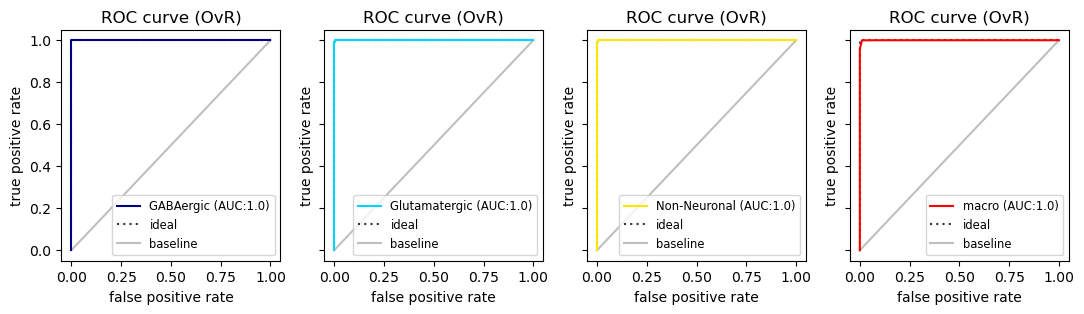

In [18]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(13, 3))

plot_roc(tuned_model, conf.test_data, test_label_bin, ax, cmap="jet", label_dict=label_dict)

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/roc_important_feat.png", **conf.fig_kwarg)